In [1]:
"""
Optuna example that optimizes a classifier configuration for cancer dataset using
Catboost.

In this example, we optimize the validation accuracy of cancer detection using
Catboost. We optimize both the choice of booster model and their hyperparameters.

"""

import catboost as cb
import numpy as np
import optuna
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier

from ml.utils import load_cleaned_dataset, load_dataset, load_picked_dataset


/Users/emax/miniconda3/envs/cs/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_loader = load_picked_dataset

In [3]:
from sklearn.discriminant_analysis import StandardScaler

data, target = dataset_loader()
train_x, valid_x, train_y, valid_y = train_test_split(
    data, target, test_size=0.2, stratify=target
)
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
valid_x = scaler.transform(valid_x)

train_y

94    -1
86     1
52     0
91     1
52    -1
      ..
81    -1
73     1
115   -1
90    -1
66    -1
Name: QA, Length: 258, dtype: int64

In [4]:
gbm = cb.CatBoostClassifier(
    # objective="CrossEntropy",
    colsample_bylevel=0.029118546446743533,
    depth=7,
    boosting_type="Ordered",
    bootstrap_type="Bernoulli",
    subsample=0.4292737612906373,
    verbose=False,
    loss_function="MultiClass",
)

gbm.fit(train_x, train_y.to_numpy())

In [5]:
def objective(trial):
    param = {
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical(
            "boosting_type", ["Ordered", "Plain"]
        ),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "4gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param, verbose=False, loss_function="MultiClass")

    gbm.fit(train_x, train_y)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    f1 = f1_score(valid_y, pred_labels, average="weighted")
    return f1


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-02-14 17:53:14,058] A new study created in memory with name: no-name-d4a4a707-12e2-4f03-9b19-5e133fb80196
[I 2024-02-14 17:53:14,354] Trial 0 finished with value: 0.7081391941391941 and parameters: {'colsample_bylevel': 0.037781677532042396, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.601040367987264}. Best is trial 0 with value: 0.7081391941391941.
[I 2024-02-14 17:53:14,624] Trial 1 finished with value: 0.7171428571428571 and parameters: {'colsample_bylevel': 0.030107451114431343, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.7171428571428571.
[I 2024-02-14 17:53:14,715] Trial 2 finished with value: 0.6968529014844804 and parameters: {'colsample_bylevel': 0.05273666325939153, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8960790687602236}. Best is trial 1 with value: 0.7171428571428571.
[I 2024-02-14 17:53:14,847] Trial 3 finished with v

Number of finished trials: 200
Best trial:
  Value: 0.7945502269709416
  Params: 
    colsample_bylevel: 0.08928043914152614
    depth: 8
    boosting_type: Ordered
    bootstrap_type: MVS


<Axes: >

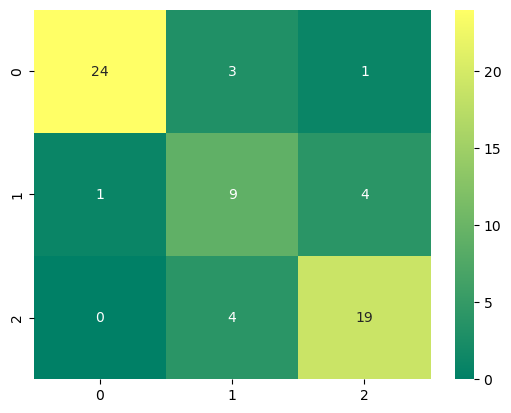

In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

gbm = cb.CatBoostClassifier(**trial.params, verbose=False, loss_function="MultiClass")
# gbm = OneVsOneClassifier(estimator=cb.CatBoostClassifier(**trial.params, verbose=False))
gbm.fit(train_x, train_y)

preds = gbm.predict(valid_x)
pred_labels = np.rint(preds)

sns.heatmap(confusion_matrix(pred_labels, valid_y), annot=True, cmap="summer")

In [7]:
# Make predictions on the test set
from sklearn.metrics import classification_report

y_pred = gbm.predict(valid_x)

# Evaluate the model
accuracy = accuracy_score(valid_y, y_pred)
report = classification_report(valid_y, y_pred)
# printing metrics
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Accuracy: 0.8
Classification Report:
               precision    recall  f1-score   support

          -1       0.86      0.96      0.91        25
           0       0.64      0.56      0.60        16
           1       0.83      0.79      0.81        24

    accuracy                           0.80        65
   macro avg       0.78      0.77      0.77        65
weighted avg       0.79      0.80      0.79        65



In [8]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

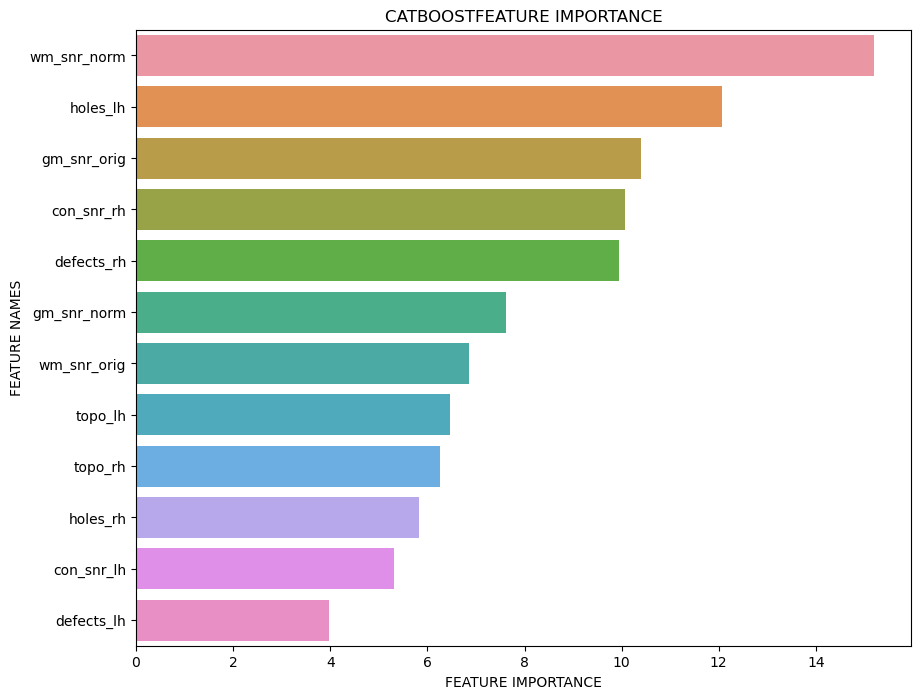

In [9]:
plot_feature_importance(gbm.get_feature_importance(), data.columns, "CATBOOST")

In [10]:
# # Convert into ONNX format.
# from skl2onnx import to_onnx

# data, target = load_dataset()
# train_x, valid_x, train_y, valid_y = train_test_split(
#     data, target, test_size=0.2, stratify=target
# )


# onx = to_onnx(gbm, data[:1].to_numpy())
# with open("rf_iris.onnx", "wb") as f:
#     f.write(onx.SerializeToString())

# # Compute the prediction with onnxruntime.
# import onnxruntime as rt

# sess = rt.InferenceSession("rf_iris.onnx", providers=["CPUExecutionProvider"])
# input_name = sess.get_inputs()[0].name
# label_name = sess.get_outputs()[0].name
# pred_onx = sess.run([label_name], {input_name: valid_x.astype(np.float32)})[0]

In [11]:
import joblib

catboost_model_name = f"catboost_model{accuracy:.2f}.pkl"

joblib.dump(gbm, catboost_model_name)

model = joblib.load(catboost_model_name)

In [12]:
from sklearn.metrics import classification_report

y_pred = model.predict(valid_x)

# Evaluate the model
accuracy = accuracy_score(valid_y, y_pred)
report = classification_report(valid_y, y_pred)
# printing metrics
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Accuracy: 0.8
Classification Report:
               precision    recall  f1-score   support

          -1       0.86      0.96      0.91        25
           0       0.64      0.56      0.60        16
           1       0.83      0.79      0.81        24

    accuracy                           0.80        65
   macro avg       0.78      0.77      0.77        65
weighted avg       0.79      0.80      0.79        65



Prev:
Accuracy: 0.8490566037735849
Classification Report:
               precision    recall  f1-score   support

          -1       0.91      0.95      0.93        21
           0       0.73      0.62      0.67        13
           1       0.85      0.89      0.87        19

    accuracy                           0.85        53
   macro avg       0.83      0.82      0.82        53
weighted avg       0.84      0.85      0.84        53

In [14]:
from sklearn.pipeline import Pipeline, make_pipeline

pipeline = make_pipeline(scaler, gbm)

In [15]:
catboost_model_name = f"catboost_model{accuracy:.2f}_pipeline.pkl"

joblib.dump(pipeline, catboost_model_name)

model = joblib.load(catboost_model_name)